# Information Maximizing Generative Adversarial Networks (InfoGANs)
|          Name        |      Class    | Admin No.|
|----------------------|---------------|----------|
| Timothy Chia Kai Lun | DAAA/FT/2B/02 | p2106911 |

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from IPython import display
from tensorflow.data import Dataset

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Embedding, Reshape, Flatten, Dropout, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D, Concatenate
from tensorflow_addons.layers import InstanceNormalization

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from utils import FrechetInceptionDistance

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

In [3]:
# set gpu memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# set random seed
tf.random.set_seed(42)
np.random.seed(42)

## Load Dataset

In [5]:
FILE_PATH = 'data\cifar10.tfrecords'
dataset = Dataset.load(FILE_PATH)
print(dataset.element_spec)

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))


## Defining Generator

In [6]:
def create_generator(latent_dim):

    # foundation for label embedded input (categorical variable)
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    
    # linear activation
    label_embedding = Dense(4 * 4, name='label_dense')(label_embedding)

    # reshape to additional channel
    label_embedding = Reshape((4, 4, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 4, 4, 1)

    # continuous features from range [-1, 1] (continuous variable)
    style_input = Input(shape=(1,), name='style_input')
    style_embedding = Dense(4 * 4, name='style_dense')(style_input)
    style_embedding = Reshape((4, 4, 1), name='style_reshape')(style_embedding)
    assert style_embedding.shape == (None, 4, 4, 1)

    # foundation for 4x4 image input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    noise_dense = Dense(4 * 4 * 128, name='noise_dense')(noise_input)
    noise_dense = ReLU(name='noise_relu')(noise_dense)
    noise_reshape = Reshape((4, 4, 128), name='noise_reshape')(noise_dense)
    assert noise_reshape.shape == (None, 4, 4, 128)

    # concatenate label embedding and image to produce 129-channel output
    concat = Concatenate(name='concat')([noise_reshape, label_embedding, style_embedding])
    assert concat.shape == (None, 4, 4, 130)

    # upsample to 8x8
    conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 8, 8, 128)
    # conv1 = InstanceNormalization(name='conv1_norm')(conv1)
    conv1 = LeakyReLU(alpha=0.2, name='conv1_leaky_relu')(conv1)

    # upsample to 16x16
    conv2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 16, 16, 128)
    # conv2 = InstanceNormalization(name='conv2_norm')(conv2)
    conv2 = LeakyReLU(alpha=0.2, name='conv2_leaky_relu')(conv2)

    # upsample to 32x32
    conv3 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 32, 32, 128)
    # conv3 = InstanceNormalization(name='conv3_norm')(conv3)
    conv3 = LeakyReLU(alpha=0.2, name='conv3_leaky_relu')(conv3)
    
    # # output 32x32x3
    output = Conv2D(3, (3, 3), activation='tanh', padding='same', name='output')(conv3)
    assert output.shape == (None, 32, 32, 3)

    model = Model(inputs=[noise_input, label_input, style_input], outputs=output, name='generator')

    # return model
    return model

In [7]:
create_generator(latent_dim=128).summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 noise_dense (Dense)            (None, 2048)         264192      ['noise_input[0][0]']            
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                          

## Defining Discriminator

In [8]:
def create_discriminator():
    input_layer = Input(shape=(32, 32, 3), name='input_layer')

    # downsample to 16x16
    conv1 = Conv2D(128, (4, 4), strides=(2, 2), padding='same', name='conv1')(input_layer)
    assert conv1.shape == (None, 16, 16, 128)
    conv1 = LeakyReLU(alpha=0.2, name='conv1_leaky_relu')(conv1)

    # downsample to 8x8
    conv2 = Conv2D(128, (4, 4), strides=(2, 2), padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 8, 8, 128)
    conv2 = LeakyReLU(alpha=0.2, name='conv2_leaky_relu')(conv2)

    # downsample to 4x4
    conv3 = Conv2D(128, (4, 4), strides=(2, 2), padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 4, 4, 128)
    conv3 = LeakyReLU(alpha=0.2, name='conv3_leaky_relu')(conv3)

    # flatten feature maps
    flat = Flatten(name='flat')(conv3)
    assert flat.shape == (None, 2048)
    d_flc = Dense(1024, name='dense')(flat)
    d_flc = LeakyReLU(alpha=0.2, name='dense_leaky_relu')(d_flc)

    # real/fake output
    d_out = Dense(1, activation='sigmoid', name='d_out')(d_flc)

    q_flc = Dense(128, name='q_dense')(flat)
    q_flc = LeakyReLU(alpha=0.2, name='q_dense_leaky_relu')(q_flc)

    # class label output
    q_out = Dense(10, activation='softmax', name='q_out')(q_flc)

    # distribution mean output
    mu_out = Dense(1, activation='linear', name='mean')(q_flc)

    # distribution std output
    std_out = Dense(1, activation=lambda x: tf.math.exp(x), name='std')(q_flc)

    # discriminator 
    d_model = Model(inputs=input_layer, outputs=d_out, name='discriminator')

    # auxiliary classifier
    q_model = Model(inputs=input_layer, outputs=[q_out, mu_out, std_out], name='auxiliary_classifier')

    return d_model, q_model

In [9]:
create_discriminator()[0].summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 128)       6272      
                                                                 
 conv1_leaky_relu (LeakyReLU  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 128)         262272    
                                                                 
 conv2_leaky_relu (LeakyReLU  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 128)       

In [10]:
create_discriminator()[1].summary()

Model: "auxiliary_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 128)  6272        ['input_layer[0][0]']            
                                                                                                  
 conv1_leaky_relu (LeakyReLU)   (None, 16, 16, 128)  0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 8, 8, 128)    262272      ['conv1_leaky_relu[0][0]']       
                                                                               

## Defining InfoGAN

In [11]:
class InfoGAN(Model):
    def __init__(self, generator, discriminator, auxiliary_classifier, latent_dim, label_smoothing):
        super(InfoGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.auxiliary_classifier = auxiliary_classifier
        self.latent_dim = latent_dim
        self.label_smoothing = label_smoothing

    def compile(self, g_optimizer, d_optimizer, aux_optimizer):
        super(InfoGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.aux_optimizer = aux_optimizer
        self.bce = BinaryCrossentropy(label_smoothing=self.label_smoothing)
        self.cce = SparseCategoricalCrossentropy()
        self.g_loss_metric = Mean(name='g_loss')
        self.d_loss_metric = Mean(name='d_loss')
        self.aux_loss_metric = Mean(name='aux_loss')
        self.aux_acc_metric = SparseCategoricalAccuracy(name='aux_acc')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric, self.aux_loss_metric, self.aux_acc_metric]

    def create_generator_input(self, batch_size):
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        label = tf.random.uniform(shape=(batch_size,), minval=0, maxval=10, dtype=tf.int32)
        style = tf.random.uniform(shape=(batch_size,), minval=-1, maxval=1)

        return noise, label, style

    def train_step(self, data):
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]

        # create generator input
        noise, label, style = self.create_generator_input(batch_size)

        # freeze generator and auxiliary classifier
        self.discriminator.trainable = True
        self.generator.trainable = False
        self.auxiliary_classifier.trainable = False

        # train discriminator
        with tf.GradientTape() as disc_tape:
            disc_tape.watch(self.discriminator.trainable_variables)
            # generate fake images
            fake_images = self.generator([noise, label, style], training=True)
            # discriminate real images
            real_output = self.discriminator(real_images, training=True)
            # discriminate fake images
            fake_output = self.discriminator(fake_images, training=True)
            # calculate discriminator loss
            d_real_loss = self.bce(tf.ones_like(real_output), real_output)
            d_fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
            d_loss = d_real_loss + d_fake_loss

        # calculate discriminator gradients
        d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update discriminator weights
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # freeze discriminator 
        self.discriminator.trainable = False
        self.generator.trainable = True
        self.auxiliary_classifier.trainable = True

        # train generator and auxiliary classifier
        with tf.GradientTape() as gen_tape, tf.GradientTape() as aux_tape:
            gen_tape.watch(self.generator.trainable_variables)
            aux_tape.watch(self.auxiliary_classifier.trainable_variables)
            # generate fake images
            fake_images = self.generator([noise, label, style], training=True)
            # discriminate fake images
            fake_output = self.discriminator(fake_images, training=True)
            # classify fake images
            q_output, mu_output, std_output = self.auxiliary_classifier(fake_images, training=True)
            # calculate generator loss
            g_loss = self.bce(tf.ones_like(fake_output), fake_output)
            # calculate auxiliary classifier loss
            aux_loss = self.cce(real_labels, q_output) + tf.reduce_mean((mu_output - tf.expand_dims(style, axis=1))**2) + tf.reduce_mean((std_output - 1)**2)

        # calculate generator gradients
        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        # update generator weights
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # calculate auxiliary classifier gradients
        aux_grads = aux_tape.gradient(aux_loss, self.auxiliary_classifier.trainable_variables)
        # update auxiliary classifier weights
        self.aux_optimizer.apply_gradients(zip(aux_grads, self.auxiliary_classifier.trainable_variables))

        # update metrics
        self.g_loss_metric.update_state(g_loss)
        self.d_loss_metric.update_state(d_loss)
        self.aux_loss_metric.update_state(aux_loss)

        return {
            'g_loss': self.g_loss_metric.result(),
            'd_loss': self.d_loss_metric.result(),
            'aux_loss': self.aux_loss_metric.result(),
        }


In [12]:
class GANMonitor(Callback):
    def __init__(self, latent_dim, label_map):
        self.latent_dim = latent_dim
        self.label_map = label_map

    def on_epoch_end(self, epoch, logs=None):
        # plot 100 generated images and save weights every 10 epochs
        latent_vectors = tf.random.normal(shape=(100, self.latent_dim))

        class_labels = tf.reshape(tf.range(10), shape=(10, 1))
        class_labels = tf.tile(class_labels, multiples=(1, 10))
        class_labels = tf.reshape(class_labels, shape=(100, 1))

        style_vectors = tf.random.uniform(shape=(100,), minval=-1, maxval=1)

        generated_images = self.model.generator([latent_vectors, class_labels, style_vectors], training=False)
        generated_images = (generated_images + 1) / 2

        if not os.path.exists('assets/infogan'):
            os.makedirs('assets/infogan')

        if not os.path.exists('images/infogan_images'):
            os.makedirs('images/infogan_images')

        if (epoch + 1) % 10 == 0:
            if not os.path.exists(f'assets/infogan/epoch_{epoch + 1}'):
                os.makedirs(f'assets/infogan/epoch_{epoch + 1}')
                self.model.generator.save_weights(f'assets/infogan/epoch_{epoch + 1}/generator_weights_epoch_{epoch + 1}.h5')
                self.model.discriminator.save_weights(f'assets/infogan/epoch_{epoch + 1}/discriminator_weights_epoch_{epoch + 1}.h5')
                print(f'\n\nSaving weights at epoch {epoch + 1}\n')

            fig, axes = plt.subplots(10, 10, figsize=(20, 20))
            axes = axes.flatten()

            for i, ax in enumerate(axes):
                ax.imshow(generated_images[i])
                ax.set_title(self.label_map[class_labels[i].numpy().item()], fontsize=16)
                ax.axis('off')

            plt.tight_layout()
            plt.savefig(f'images/infogan_images/generated_img_{epoch + 1}.png')
            plt.close()

In [13]:
EPOCHS = 200
LATENT_DIM = 128    
LEARNING_RATE = 2e-4
BETA_1 = 0.5
LABEL_SMOOTHING = 0.1

# create label map
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

callbacks = [GANMonitor(LATENT_DIM, label_map)]

generator = create_generator(LATENT_DIM)
discriminator, auxiliary_classifier = create_discriminator()
infogan = InfoGAN(
    generator=generator,
    discriminator=discriminator,
    auxiliary_classifier=auxiliary_classifier,
    latent_dim=LATENT_DIM,
    label_smoothing=LABEL_SMOOTHING,
)

infogan.compile(
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
    aux_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
)

In [14]:
%%time
history = infogan.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/200
467/467 [==============================] - 49s 86ms/step - g_loss: 0.7713 - d_loss: 1.3511 - aux_loss: 2.6362
Epoch 2/200
467/467 [==============================] - 39s 84ms/step - g_loss: 0.8188 - d_loss: 1.3481 - aux_loss: 2.6310
Epoch 3/200
467/467 [==============================] - 39s 85ms/step - g_loss: 0.7688 - d_loss: 1.3824 - aux_loss: 2.6016
Epoch 4/200
467/467 [==============================] - 42s 90ms/step - g_loss: 0.7730 - d_loss: 1.3986 - aux_loss: 2.3857
Epoch 5/200
467/467 [==============================] - 43s 91ms/step - g_loss: 0.7521 - d_loss: 1.3823 - aux_loss: 2.3613
Epoch 6/200
467/467 [==============================] - 40s 85ms/step - g_loss: 0.7524 - d_loss: 1.3773 - aux_loss: 2.3765
Epoch 7/200
467/467 [==============================] - 39s 83ms/step - g_loss: 0.7579 - d_loss: 1.3814 - aux_loss: 2.3932
Epoch 8/200
467/467 [==============================] - 39s 83ms/step - g_loss: 0.7565 - d_loss: 1.3814 - aux_loss: 2.3906
Epoch 9/200
467/467 [===

## Model Evaluation

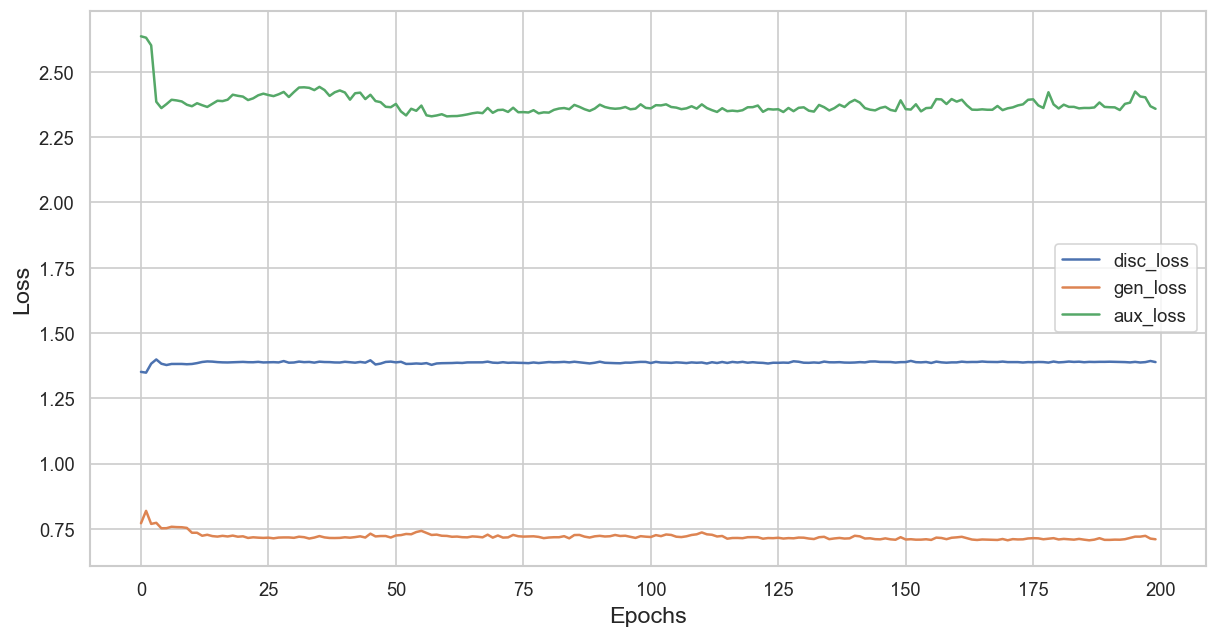

In [15]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_loss'], label='disc_loss')
plt.plot(history.history['g_loss'], label='gen_loss')
plt.plot(history.history['aux_loss'], label='aux_loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()
plt.show()

In [16]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_acc'], label='aux_acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.show()

KeyError: 'd_acc'

<Figure size 1440x720 with 0 Axes>